In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#import importlib
#import SupportFunctions
importlib.reload(SupportFunctions)
from SupportFunctions import check_stationarity, print_metrics, plot_correlation_matrix, plot_columns_vs_index_subgrid


In [1]:
df = pd.read_csv('Sample_TS_data.csv')
df.head()

,utc_timestamp,wind_generation_actual,wind_capacity,temperature
0,2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
1,2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2,2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
3,2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
4,2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908


In [5]:
df['capacity_factor'] = df['wind_generation_actual'] / df['wind_capacity']
df.head(20)

,utc_timestamp,wind_generation_actual,wind_capacity,temperature,capacity_factor
0,2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117,7.853751
1,2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154,7.942937
2,2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239,17.929384
3,2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620,18.476283
4,2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908,7.043435
5,2017-01-06 00:00:00+00:00,115720.0,37176.208,-7.724,3.112744
6,2017-01-07 00:00:00+00:00,252308.0,37181.000,-5.861,6.785939
7,2017-01-08 00:00:00+00:00,41260.0,37181.250,-1.616,1.109699
8,2017-01-09 00:00:00+00:00,190982.0,37187.458,-1.629,5.135656
9,2017-01-10 00:00:00+00:00,280371.0,37198.458,-2.586,7.537167


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   utc_timestamp           1094 non-null   object 
 1   wind_generation_actual  1094 non-null   float64
 2   wind_capacity           1094 non-null   float64
 3   temperature             1094 non-null   float64
 4   capacity_factor         1094 non-null   float64
dtypes: float64(4), object(1)
memory usage: 42.9+ KB


In [9]:
df.describe()

,wind_generation_actual,wind_capacity,temperature,capacity_factor
count,1094.000000,1094.000000,1094.000000,1094.000000
mean,305819.767824,45066.022789,10.050167,6.793693
std,205728.857915,4315.838061,7.739158,4.543175
min,16482.000000,37149.130000,-9.363000,0.401940
25%,148552.750000,41447.937500,3.577250,3.236328
50%,254332.500000,46073.000000,10.046500,5.658069
75%,412570.500000,49203.000000,16.566000,9.179512
max,998899.000000,50452.000000,28.241000,21.894986


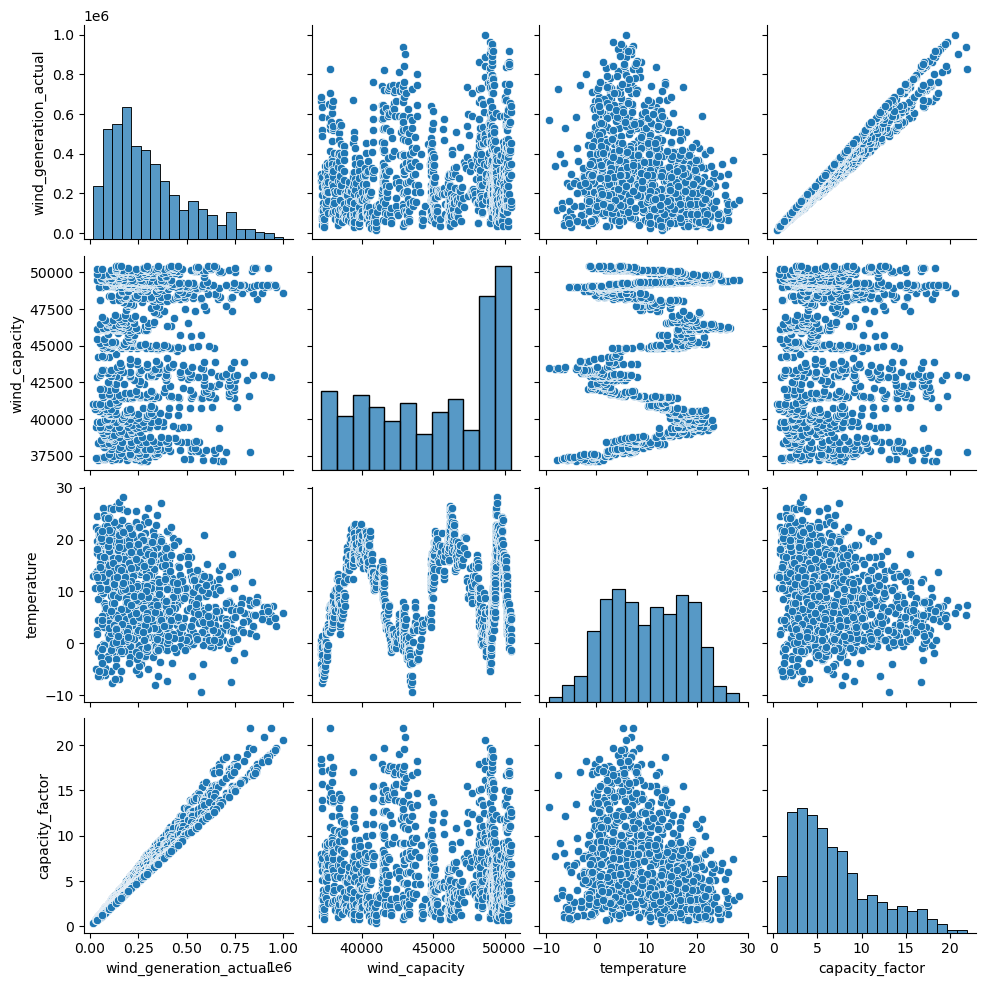

In [23]:
sns.pairplot(df)
plt.show()

/Users/nserkes/Documents/Baruch/Interview Prep/SupportFunctions.py:42: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


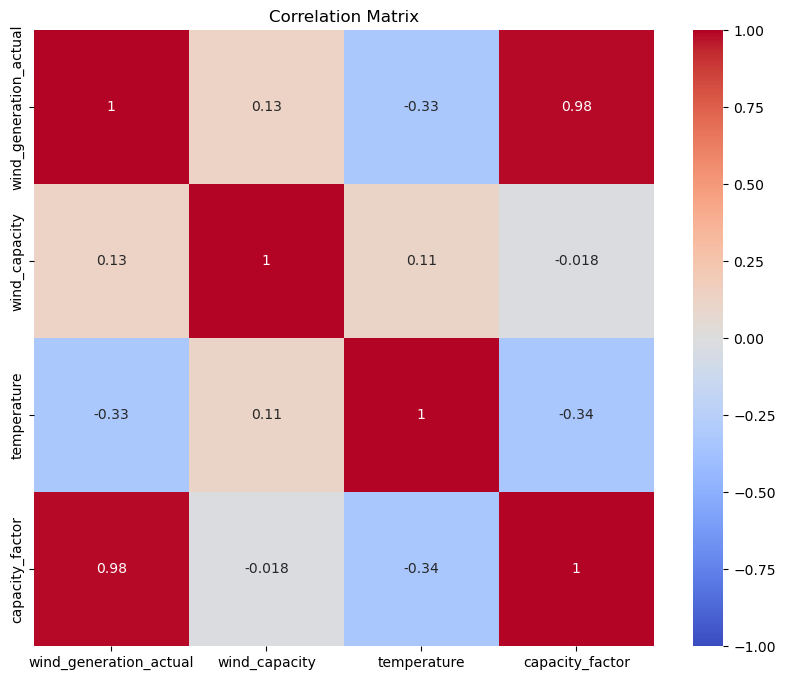

,wind_generation_actual,wind_capacity,temperature,capacity_factor
wind_generation_actual,1.000000,0.127708,-0.325831,0.984849
wind_capacity,0.127708,1.000000,0.112132,-0.017608
temperature,-0.325831,0.112132,1.000000,-0.339972
capacity_factor,0.984849,-0.017608,-0.339972,1.000000


In [44]:
plot_correlation_matrix(df)

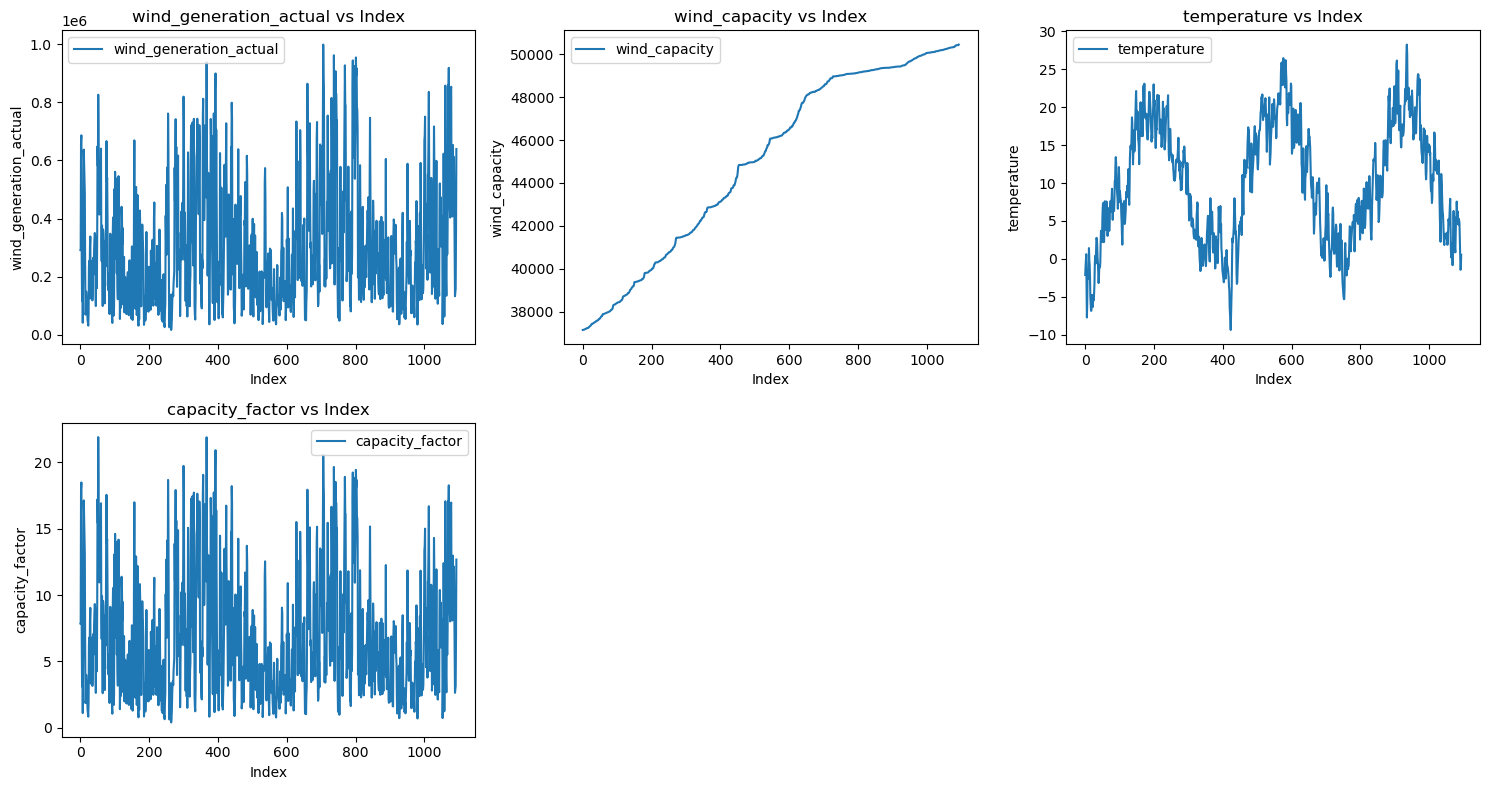

In [28]:
plot_columns_vs_index_subgrid(df.iloc[:, 1:])

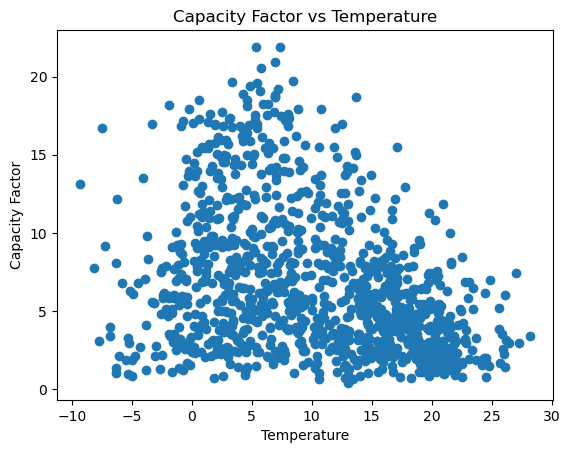

In [14]:
plt.scatter(df['temperature'], df['capacity_factor'])
plt.title('Capacity Factor vs Temperature')
plt.ylabel('Capacity Factor')
plt.xlabel('Temperature')
plt.show()

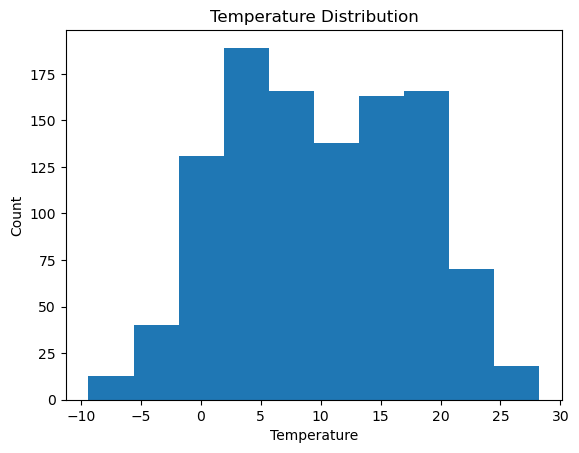

In [15]:
plt.hist(df['temperature'])
plt.title('Temperature Distribution')
plt.ylabel('Count')
plt.xlabel('Temperature')
plt.show()

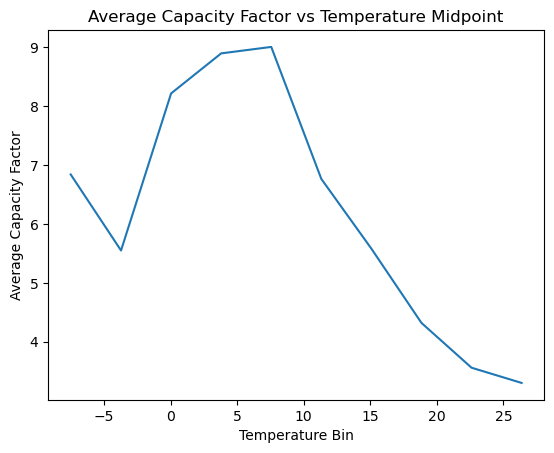

In [20]:
# Define the bins for temperature, e.g., 10 bins from the min to max temperature
bins = pd.cut(df['temperature'], bins=10)

# Group by the temperature bins and calculate the mean capacity factor for each bin
average_capacity_per_bin = df.groupby(bins)['capacity_factor'].mean()

# Convert to a DataFrame for easy viewing
average_capacity_per_bin_df = average_capacity_per_bin.reset_index()
average_capacity_per_bin_df['Temperature Midpoint'] = average_capacity_per_bin_df['temperature'].apply(lambda x: x.mid)
average_capacity_per_bin_df.columns = ['Temperature Bin', 'Average Capacity Factor', 'Temperature Midpoint']

plt.plot(average_capacity_per_bin_df['Temperature Midpoint'], average_capacity_per_bin_df['Average Capacity Factor'])
plt.title('Average Capacity Factor vs Temperature Midpoint')
plt.ylabel('Average Capacity Factor')
plt.xlabel('Temperature Bin')
plt.show()


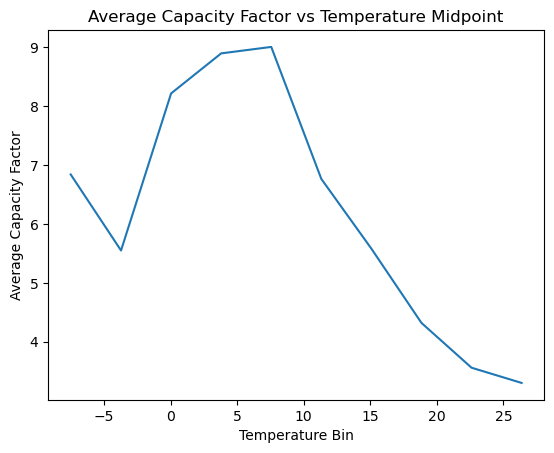

In [21]:
# Define the bins for temperature, e.g., 10 bins from the min to max temperature
bins = pd.cut(df['temperature'], bins=10)

# Group by the temperature bins and calculate the mean and count for each bin
average_capacity_per_bin = df.groupby(bins).agg(
    Average_Capacity_Factor=('capacity_factor', 'mean'),
    Count=('capacity_factor', 'size')
)

# Convert to a DataFrame for easy viewing
average_capacity_per_bin_df = average_capacity_per_bin.reset_index()
average_capacity_per_bin_df['Temperature Midpoint'] = average_capacity_per_bin_df['temperature'].apply(lambda x: x.mid)
average_capacity_per_bin_df.columns = ['Temperature Bin', 'Average Capacity Factor', 'Count', 'Temperature Midpoint']

plt.plot(average_capacity_per_bin_df['Temperature Midpoint'], average_capacity_per_bin_df['Average Capacity Factor'])
plt.title('Average Capacity Factor vs Temperature Midpoint')
plt.ylabel('Average Capacity Factor')
plt.xlabel('Temperature Bin')
plt.show()


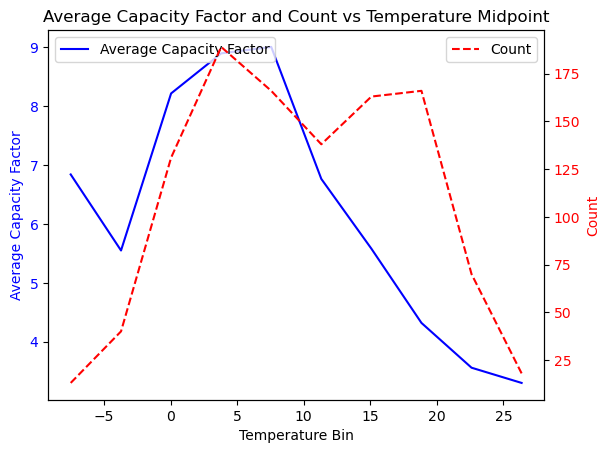

In [22]:
# Plot the Average Capacity Factor with Temperature Midpoint on the primary y-axis
fig, ax1 = plt.subplots()

# Plot for Average Capacity Factor
ax1.plot(average_capacity_per_bin_df['Temperature Midpoint'], 
         average_capacity_per_bin_df['Average Capacity Factor'], 
         color='b', label='Average Capacity Factor')
ax1.set_xlabel('Temperature Bin')
ax1.set_ylabel('Average Capacity Factor', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Average Capacity Factor and Count vs Temperature Midpoint')

# Create a secondary y-axis for the Count
ax2 = ax1.twinx()
ax2.plot(average_capacity_per_bin_df['Temperature Midpoint'], 
         average_capacity_per_bin_df['Count'], 
         color='r', linestyle='--', label='Count')
ax2.set_ylabel('Count', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding legends for both lines
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [2]:
# Creating the first DataFrame with integer keys as column names
df1 = pd.DataFrame({
    1: [10, 20, 30],
    2: [40, 50, 60],
    3: [70, 80, 90]
})

# Creating the second DataFrame with key-title pairs
df2 = pd.DataFrame({
    'key': [1, 2, 3],
    'title': ['Column A', 'Column B', 'Column C']
})

# Creating a mapping dictionary from df2 for renaming
column_mapping = dict(zip(df2['key'], df2['title']))

# Renaming the columns in df1 using the mapping from df2
df1_renamed = df1.rename(columns=column_mapping)

# Displaying the dataframes for verification
print("Original DataFrame (df1):\n", df1)
print("\nMapping DataFrame (df2):\n", df2)
print("\nRenamed DataFrame (df1_renamed):\n", df1_renamed)

Original DataFrame (df1):
     1   2   3
0  10  40  70
1  20  50  80
2  30  60  90

Mapping DataFrame (df2):
    key     title
0    1  Column A
1    2  Column B
2    3  Column C

Renamed DataFrame (df1_renamed):
    Column A  Column B  Column C
0        10        40        70
1        20        50        80
2        30        60        90


In [32]:
df['temperature']

0      -2.117
1      -1.154
2      -0.239
3       0.620
4      -3.908
        ...  
1089    2.790
1090    1.327
1091   -1.441
1092   -1.314
1093    0.542
Name: temperature, Length: 1094, dtype: float64

In [36]:
from SupportFunctions import check_stationarity
check_stationarity(df['temperature'])

ADF Statistic: -2.247840
p-value: 0.189343
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary
